In [42]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sm_tsa
from random import random
pd.set_option('display.max_rows', 10)

In [43]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)
df_hospital

,Week,ILI
0,15-2015,12311
1,16-2015,11021
2,17-2015,11311
3,18-2015,10946
4,19-2015,9891
...,...,...
223,30-2019,7755
224,31-2019,7851
225,32-2019,8031
226,33-2019,8933


In [44]:
df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)
df_twitter

,Week,Tweets
0,15-2015,429
1,16-2015,386
2,17-2015,352
3,18-2015,387
4,19-2015,450
...,...,...
223,30-2019,367
224,31-2019,321
225,32-2019,354
226,33-2019,292


In [45]:
df_us = pd.read_csv('../data/USA_flu_virus_counts.csv')
df_us['Week'] = df_us.Week.map(str) + "-" + df_us.Year.map(str)
df_us = df_us[['Week', 'ALL_INF']]
df_us = df_us[786+27:1042]
df_us = df_us.drop(851)
df_us = df_us.reset_index(drop=True)
df_us

,Week,ALL_INF
0,15-2015,1472
1,16-2015,1127
2,17-2015,772
3,18-2015,609
4,19-2015,527
...,...,...
223,30-2019,253
224,31-2019,248
225,32-2019,222
226,33-2019,265


In [46]:
df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)
df_aus

,Week,ALL_INF
0,40-2014,72
1,41-2014,58
2,42-2014,29
3,43-2014,28
4,44-2014,24
...,...,...
223,3-2019,125
224,4-2019,97
225,5-2019,110
226,6-2019,106


In [64]:
df_google = pd.read_csv('../data/flu_trends_past5years.csv')
df_google['Week'] = df_google.Week.map(str) + "-" + df_google.Year.map(str)
df_google = df_google[['Week', 'Searches']]
df_google = df_google[21:250]
df_google = df_google.drop(86)
df_google.reset_index(drop=True)
df_google

,Week,Searches
21,15-2015,9
22,16-2015,9
23,17-2015,7
24,18-2015,6
25,19-2015,6
...,...,...
245,30-2019,4
246,31-2019,5
247,32-2019,5
248,33-2019,7


In [66]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_us = list(df_us['ALL_INF'])
list_aus = list(df_aus['ALL_INF'])
list_google = list(df_google['Searches'])

# list_tweets = [i / 5000 for i in list_tweets]
# list_hospital = [i / 50 for i in list_hospital]
# list_us = [i / 20 for i in list_us]

# list_hospital = [float(i)/sum(list_hospital) for i in list_hospital]
# list_tweets = [float(i)/sum(list_tweets) for i in list_tweets]
# list_us = [float(i)/sum(list_us) for i in list_us]
# list_aus_norm = [float(i)/sum(list_aus) for i in list_aus]

In [67]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

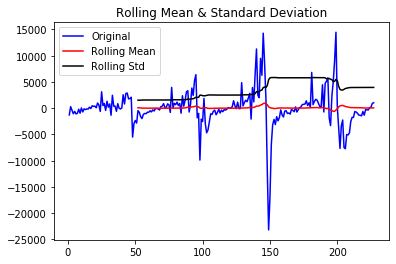

Results of Dickey-Fuller Test:
Test Statistic                  -4.328583
p-value                          0.000396
#Lags Used                       9.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [50]:
df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(1)
# df_hospital['first_difference'] = df_hospital.ILI - df_hospital.ILI.shift(52)

# test_stationarity(df.first_difference.dropna(inplace=False))
test_stationarity(df_hospital.first_difference.dropna(inplace=False))

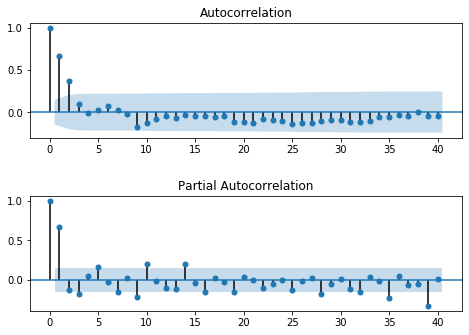

In [51]:
fig = plt.figure()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.5)
ax1 = fig.add_subplot(211)
fig = sm_tsa.plot_acf(df_hospital.first_difference.iloc[53:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm_tsa.plot_pacf(df_hospital.first_difference.iloc[53:], lags=40, ax=ax2)

In [68]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_us_real = list_us[:-52]
list_aus_real = list_aus[:-52]
list_google_real = list_google[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_us_pred = list_us[-52:]
list_aus_pred = list_aus[-52:]
list_google_pred = list_google[-52:]

In [80]:
# features = [list_tweets_real, list_us_real, list_aus_real, list_google_real]
# pred = [list_tweets_pred, list_us_pred, list_aus_pred, list_google_pred]
features = [list_tweets_real, list_aus_real, list_google_real]
pred = [list_tweets_pred, list_aus_pred, list_google_pred]

In [81]:
features = list(map(list, zip(*features)))
pred = list(map(list, zip(*pred)))

In [82]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit()

In [83]:
# make prediction
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
print(predictions)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))
# future_weeks

[ 6721.60432259  7144.49385486  8446.70802181  8503.39994213
  9006.90812286 14761.70699366 16425.00253345 16187.04874426
 18640.37839527 19402.04809873 20909.61219767 23537.46354336
 21286.53590988 23986.7707782  25184.13369767 29780.10455984
 39990.90519806 41440.2973936  40702.22473781 40886.73825004
 39965.62708095 54349.76984754 68499.71607643 71806.86677257
 65647.4047617  46921.49685995 32643.39594059 28285.55843445
 21314.56798449 20377.69899375 18391.69991605 17367.2450477
 15874.96356914 14078.24542244 13765.10972111 13289.77470862
 12408.76592243 13185.69845436 12415.10225946 11163.96135382
  9555.28813795  9996.63853661  9614.70370284  7642.41831818
  7020.37400846  7699.52513519  7384.54172736  7395.77872295
  7668.23279993  6610.01173438  8129.44383036  7993.28080006]


In [84]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI + Features: 2014 - 2019')

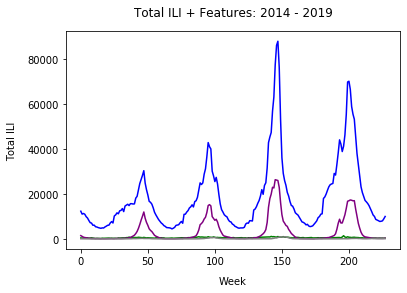

In [85]:
plt.plot(list_hospital, c='blue')
plt.plot(list_tweets, c='green')
plt.plot(list_us, c='purple')
plt.plot(list_aus, c='gray')
# plt.plot(predictions_df, '--', c='#1f77b4')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI + Features: 2014 - 2019", pad=15)

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

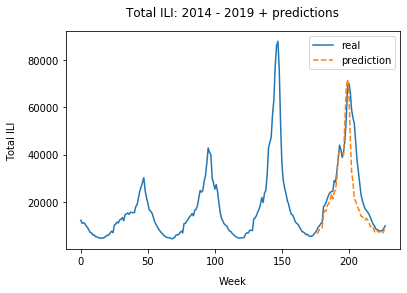

In [86]:
plt.plot(df_hospital['ILI'], label='real')
# plt.plot(predictions_df)
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [87]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1146.463
Date:                            Mon, 09 Dec 2019   AIC                           2304.926
Time:                                    17:37:56   BIC                           2321.799
Sample:                                         0   HQIC                          2311.780
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -6.9874      2.862     -2.442      0.015     -12.596      -1.378
x2             7.7241      4.037      1.913      0.056      -0.188      15.636
x3           247.7468     56.428      4.390      0.000     137.149     358.344
ar.L1          0.3553      0.117      3.025      0.002       0.125       0.586
ar.S.L52      -0.0698      0.151     -0.461      0.645      -0.366       0.227
sigma2      7.503e+06   5.61e+05     13.364      0.000     6.4e+06     8.6e+06
===================================================================================
Ljung-Box (Q):                       17.76   Jarque-Bera (JB):              1213.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.27   Skew:                            -2.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""